# Using a projectional method for reconstruction

This is code accompanying the paper [A Projectional Ansatz to Reconstruction](https://arxiv.org/abs/1907.04675).

## Basic idea
We want to solve the inverse problem
$$Ax + \eta = y + \eta = y^\delta,$$
where $A:X\to Y$ a continuous linear operator,
$\eta$ some noise with $||\eta||=\delta$ and we want to reconstuct $x$ from $y^\delta$.

## Approach
Train a neural network

$$G_\theta(A, y^\delta, \delta, x_0) := P_{\overline V(A, y^\delta, \delta)} \circ g_{\theta, n-1} \circ P_{\overline V(A, y^\delta, \delta)} \circ \cdots \circ g_{\theta, 0} \circ P_{\overline V(A, y^\delta, \delta)} (0),$$

where $P_\overline V$ the projection into the set
$$\overline V(A, y^\delta, \delta):= \{x\in X:\|Ax-y^\delta\|\le \delta\}$$

over a set of samples $(x, y^\delta)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create samples from some made up space X

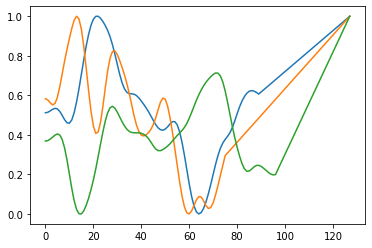

In [2]:
def get_batch(batch_size, function_length=128):
    n = function_length + 1
    fs = np.fft.irfft(np.random.normal(0, 1, [batch_size, n])*np.logspace(0,-8,n), axis=1)[:,:function_length]
    fs -= np.min(fs, axis=1).reshape(batch_size, 1)
    fs /= np.max(fs, axis=1).reshape(batch_size, 1)

    start_lin = np.random.rand(batch_size) * 64 + 64
    start_lin = start_lin.astype(int)
    for i in range(batch_size):
        fs[i, start_lin[i]:] = np.linspace(fs[i, start_lin[i]], 1, len(fs[i, start_lin[i]:]))

    return fs.T

def get_function(function_length=128):
    return get_batch(1, function_length=function_length).flatten()

for f in get_batch(3).T:
        plt.plot(f)
plt.show()

In [3]:
def get_noisy_batch(batch_size, relative_delta, function_length=1000):
    x = get_batch(batch_size, function_length=function_length)
    y = np.dot(A, x)

    delta = np.mean(np.linalg.norm(y, axis=0) * relative_delta)

    noise = np.random.normal(0, 1, y.shape)
    noise /= np.linalg.norm(noise, axis=0)
    noise *= delta

    y_delta = y + noise

    return y_delta, delta, x, y

In [4]:
function_length = 128
relative_delta = 1e-1
A = np.random.normal(0, 1, [function_length//2, function_length])

# L2 reconstruction code for comparison

In [5]:
from sklearn.linear_model import Ridge
def l2_reconstruction(A, y_delta, lamb):
    clf = Ridge(alpha=lamb)
    clf.fit(A, y_delta.flatten())
    return clf.coef_.flatten()

In [6]:
def get_best_l2(A, y_delta, x):
    best_lambda = 0
    best_i = 0
    best_rmse = np.inf

    n = 50

    for i, lamb in enumerate(np.logspace(-5, 5, n)):
        x_l2 = l2_reconstruction(A, y_delta, lamb)

        mse = np.linalg.norm(x - x_l2)**2
        rmse = mse / np.linalg.norm(x)**2

        if rmse < best_rmse:
            best_rmse = rmse
            best_lambda = lamb
            best_i = i

    lamb_min = np.logspace(-5, 5, n)[int(np.clip(best_i-1, 0, n-1))]
    lamb_max = np.logspace(-5, 5, n)[int(np.clip(best_i+1, 0, n-1))]

    for lamb in np.linspace(lamb_min, lamb_max, n):
        x_l2 = l2_reconstruction(A, y_delta, lamb)

        mse = np.linalg.norm(x - x_l2)**2
        rmse = mse / np.linalg.norm(x)**2

        if rmse <= best_rmse:
            best_rmse = rmse
            best_lambda = lamb

    return l2_reconstruction(A, y_delta, best_lambda)

# Load libs for Deep Learning part

In [7]:
import torch

from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

A_torch = torch.cuda.FloatTensor(A)
A_torch = A_torch.requires_grad_(False)

# CG-method implementation

In [8]:
def custom_torch_cg(A, mu, b, tol=1e-12, verbose=False):
    """
    CG method for Mx=b
    where M = 1 + mu * A.T A
    """
    def timesM(x):
        return x + mu * torch.mm(A.t(), torch.mm(A, x))

    x = torch.clone(b)

    r = b - timesM(x)
    p = r
    eps = tol * torch.norm(b)

    if torch.norm(r) <= eps:
        return x

    i = 0
    while True:
        i += 1
        Mp = timesM(p)
        alpha = torch.sum(r**2, dim=0) / torch.sum(p * Mp, dim=0)
        alpha_p = alpha * p
        if torch.any(torch.isnan(alpha_p)):
            if verbose:
                print("Stopped cg due to nan.")
            return x
        x = x + alpha_p
        old_r = r
        r = r - alpha * Mp
        if torch.norm(r) < eps:
            return x
        beta = torch.sum(r**2, dim=0) / torch.sum(old_r**2, dim=0)
        p = r + beta * p

# Code to projection an outside point onto an "ellipse"

In [9]:
def project_into_ellipse(x_star,
                         A, y_delta, delta,
                         verbose=True,
                         EPSILON_PRECESSION=1e-2,
                         EPSILON_CG=1e-12):
    """
    Projects x_star onto the ellipse given by ||Ax-y_delta|| = delta
    """

    # How far away from boundry (relative)?
    def error(x, y_delta, sign=False):
        Ax_y = torch.mm(A, x) - y_delta
        err = (torch.norm(Ax_y, dim=0) - delta) / delta
        if sign:
            return err
        else:
            return torch.abs(err)

    # Solve Minimization for a fixed mu.
    def solve(mu, x_star, y_delta):
        b = x_star + mu * torch.mm(A.t(), y_delta)
        return custom_torch_cg(A, mu, b,
                               tol=EPSILON_CG)

    # Iteratively update mu and return solution x for final mu
    def solve_with_binary(x_star, y_delta):
        mu_neg = torch.torch.ones_like(x_star[0])
        mu_pos = torch.torch.ones_like(x_star[0])

        i = 0

        def phi_dash(mu):
            x = solve(mu, x_star, y_delta)
            Ax_y = torch.mm(A, x) - y_delta
            return (torch.norm(Ax_y, dim=0) - delta) / delta

        while True:
            i += 1
            phi_dash_mu_pos = phi_dash(mu_pos)
            if torch.any(phi_dash_mu_pos < 0):
                mu_pos[phi_dash_mu_pos < 0] /= 2
            else:
                break

        while True:
            i += 1
            phi_dash_mu_neg = phi_dash(mu_neg)
            if torch.any(phi_dash_mu_neg > 0):
                mu_neg[phi_dash_mu_neg > 0] *= 2
            else:
                break

        mu_mid = (mu_neg + mu_pos) / 2
        i += 1
        phi_dash_mid = phi_dash(mu_mid)
        while torch.any(torch.abs(phi_dash_mid) > EPSILON_PRECESSION):
            mu_neg[phi_dash_mid < 0] = mu_mid[phi_dash_mid < 0]
            mu_pos[phi_dash_mid >= 0] = mu_mid[phi_dash_mid >= 0]
            mu_mid = (mu_neg + mu_pos) / 2
            phi_dash_mid = phi_dash(mu_mid)
            i += 1

        if verbose:
            print("Binary search took", i, "cg iterations.")

        return solve(mu_mid, x_star, y_delta)

    # Which ones need to be projected, since they are outside the ellipse
    active = error(x_star, y_delta, sign=True) > 0
    # If non need to be projected, we do not need to waste any more time on this.
    if not torch.any(active):
        return x_star

    # Calculate projections and return them.
    x = torch.clone(x_star)
    x[:,active] = solve_with_binary(x_star[:,active], y_delta[:,active])

    return x

In [10]:
def agile_project_into_ellipse(x_star,
                              A, y_delta, delta,
                              verbose=True,
                              EPSILON_PRECESSION=1e-2,
                              EPSILON_CG=1e-12,
                              precession=torch.float64):
    """
    Assumes first index of x_star and y_delta runs over the samples.
    Based on this assumption this wrapper for project_into_ellipse.
    """
    def to_matrix(x, dtype=None):
        if dtype is None:
            dtype = x.dtype
        return x.view(x.shape[0], -1).t().type(dtype)

    def from_matrix(x, sample_shape, dtype=None):
        if dtype is None:
            dtype = x.dtype
        return x.t().view(-1, *sample_shape).type(dtype)

    y_sample_shape = y_delta[0].shape
    x_sample_shape = x_star[0].shape

    x_matrix = project_into_ellipse(to_matrix(x_star).type(precession),
                                    A.type(precession),
                                    to_matrix(y_delta).type(precession),
                                    delta.type(precession),
                                    verbose=verbose,
                                    EPSILON_PRECESSION=EPSILON_PRECESSION,
                                    EPSILON_CG=EPSILON_CG)

    return from_matrix(x_matrix, x_sample_shape).type(x_star.dtype)

# Wrap the projection functionality into a layer

In [11]:
EPSILON_PRECESSION = 1e-2
EPSILON_CG = 1e-9

class Projection(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_star, A, y_delta, delta):
        # Project onto the ellipse this part can be replaced by any projection algorithm
        err = torch.norm(torch.mm(A, x_star.view(-1, A.shape[1]).t()) - y_delta.t(), dim=0) - delta
        active = err >= EPSILON_PRECESSION
        x = torch.clone(x_star)
        if torch.any(active):
            x[active] = agile_project_into_ellipse(x_star[active], A, y_delta[active], delta,
                                                   verbose=False,
                                                   EPSILON_PRECESSION=EPSILON_PRECESSION,
                                                   EPSILON_CG=EPSILON_CG)

        ctx.x_star = x_star
        ctx.A = A
        ctx.y_delta = y_delta
        ctx.delta = delta
        ctx.x = x
        ctx.active = active

        return x

    @staticmethod
    def backward(ctx, dLdf_t, epsilon=1e-3):
        # Define and transform variables s.t. every column represents a data point
        A = ctx.A 
        active = ctx.active
        x_star = ctx.x_star.view(-1, A.shape[1]).t()
        y_delta = ctx.y_delta.t()
        delta = ctx.delta
        x = ctx.x.view(-1, A.shape[1]).t()
        dLdf = dLdf_t.view(-1, A.shape[1]).t()

        # Calculate mu based on forward results
        ATAx_y = torch.matmul(A.t(), torch.matmul(A, x) - y_delta)
        mu = torch.norm(x_star - x, dim=0) / torch.norm(ATAx_y, dim=0)
        mu[torch.norm(torch.matmul(A, x_star) - y_delta, dim=0) <= delta] = 0.

        # Calculate gradients to pass on
        dLdx = torch.clone(dLdf)
        if torch.any(active):
            dLdx[:,active] = custom_torch_cg(A, mu[active], dLdf[:,active], EPSILON_CG)

        dLdx_t = dLdx.t().view(dLdf_t.size())
        del ctx.A, ctx.x_star, ctx.y_delta, ctx.delta, ctx.x

        return dLdx_t, None, None, None, None

# Define example reconstruction network

In [12]:
class PriorNet(nn.Module):
    def __init__(self, function_length):
        super(PriorNet, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(function_length, function_length//2)
        self.fc2 = nn.Linear(function_length//2, function_length//4)
        self.fc3 = nn.Linear(function_length//4, function_length//2)
        self.fc4 = nn.Linear(function_length//2, function_length)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.sigmoid(self.fc4(out))
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.priornet0 = PriorNet(function_length)
        self.priornet1 = PriorNet(function_length)
        self.priornet2 = PriorNet(function_length)
        self.priornet3 = PriorNet(function_length)
        self.projection = Projection.apply

    def forward(self, x_star, A, y_delta, delta):
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet0(x)
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet1(x)
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet2(x)
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet3(x)
        x = self.projection(x_star, A, y_delta, delta)

        return x

# Set up training of the network

In [13]:
import time
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Number of batches
n_batches = 1001

# Initialize generator and critic
generator = Generator().cuda()

# Optimizers
lr = float(np.loadtxt('lr_file'))
optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

losses = []
batches_done = 0

example_rmse = []
example_rmse_l2 = []

# Train the network

[[Batch 0/1001] [G loss: 200.156372] [Seconds: 3.324953]


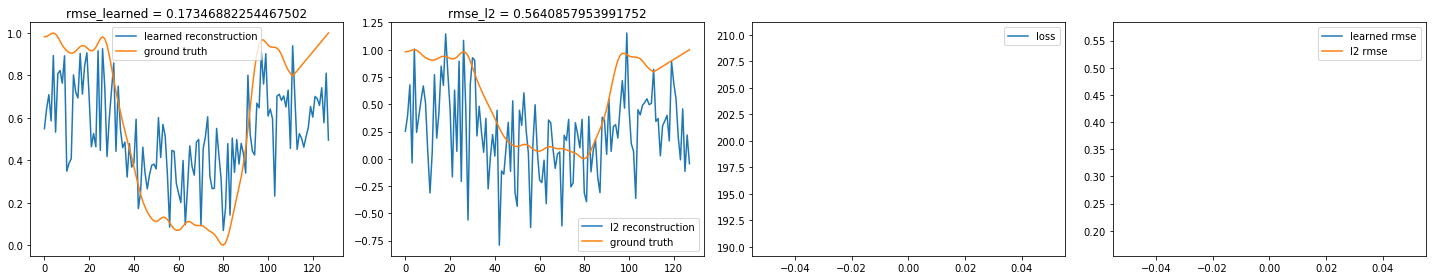

[[Batch 1/1001] [G loss: 171.886505] [Seconds: 1.892889]
[[Batch 2/1001] [G loss: 165.973755] [Seconds: 1.674029]
[[Batch 3/1001] [G loss: 201.187927] [Seconds: 2.387246]
[[Batch 4/1001] [G loss: 172.189026] [Seconds: 2.091946]
[[Batch 5/1001] [G loss: 142.149460] [Seconds: 1.889169]
[[Batch 6/1001] [G loss: 166.962860] [Seconds: 2.433471]
[[Batch 7/1001] [G loss: 163.723557] [Seconds: 2.746182]
[[Batch 8/1001] [G loss: 152.893829] [Seconds: 1.747689]
[[Batch 9/1001] [G loss: 150.707169] [Seconds: 1.519915]
[[Batch 10/1001] [G loss: 169.615875] [Seconds: 1.815084]
[[Batch 11/1001] [G loss: 160.535706] [Seconds: 1.885851]
[[Batch 12/1001] [G loss: 156.574539] [Seconds: 2.045923]
[[Batch 13/1001] [G loss: 175.780777] [Seconds: 1.616307]
[[Batch 14/1001] [G loss: 149.421265] [Seconds: 1.626082]
[[Batch 15/1001] [G loss: 150.052826] [Seconds: 2.174354]
[[Batch 16/1001] [G loss: 154.976364] [Seconds: 1.543456]
[[Batch 17/1001] [G loss: 152.318329] [Seconds: 1.673420]
[[Batch 18/1001] [G los

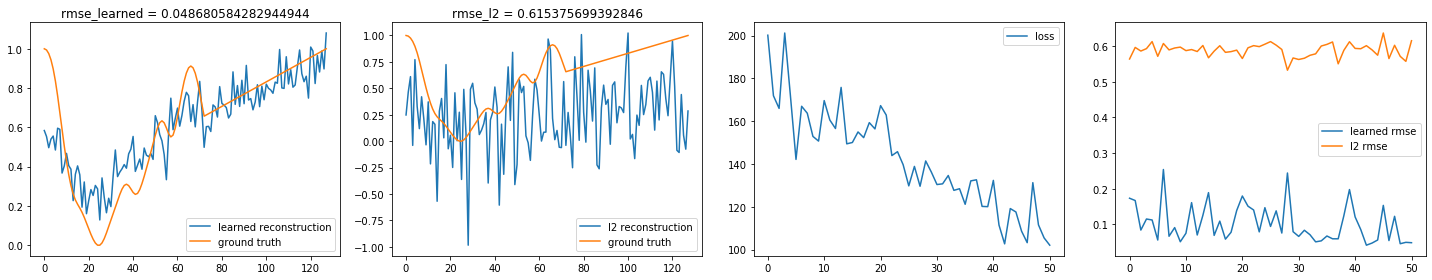

[[Batch 51/1001] [G loss: 104.233749] [Seconds: 1.542808]
[[Batch 52/1001] [G loss: 102.256531] [Seconds: 1.475474]
[[Batch 53/1001] [G loss: 95.144547] [Seconds: 1.499559]
[[Batch 54/1001] [G loss: 104.754692] [Seconds: 1.552959]
[[Batch 55/1001] [G loss: 101.169800] [Seconds: 1.464020]
[[Batch 56/1001] [G loss: 92.915428] [Seconds: 1.648446]
[[Batch 57/1001] [G loss: 100.715225] [Seconds: 1.443895]
[[Batch 58/1001] [G loss: 85.859909] [Seconds: 1.475025]
[[Batch 59/1001] [G loss: 76.919556] [Seconds: 1.467738]
[[Batch 60/1001] [G loss: 92.214668] [Seconds: 1.447307]
[[Batch 61/1001] [G loss: 102.227127] [Seconds: 1.486845]
[[Batch 62/1001] [G loss: 90.296356] [Seconds: 1.540609]
[[Batch 63/1001] [G loss: 91.584396] [Seconds: 1.555470]
[[Batch 64/1001] [G loss: 88.107979] [Seconds: 1.547286]
[[Batch 65/1001] [G loss: 106.693192] [Seconds: 1.541821]
[[Batch 66/1001] [G loss: 89.691437] [Seconds: 1.455072]
[[Batch 67/1001] [G loss: 92.596519] [Seconds: 1.465924]
[[Batch 68/1001] [G loss

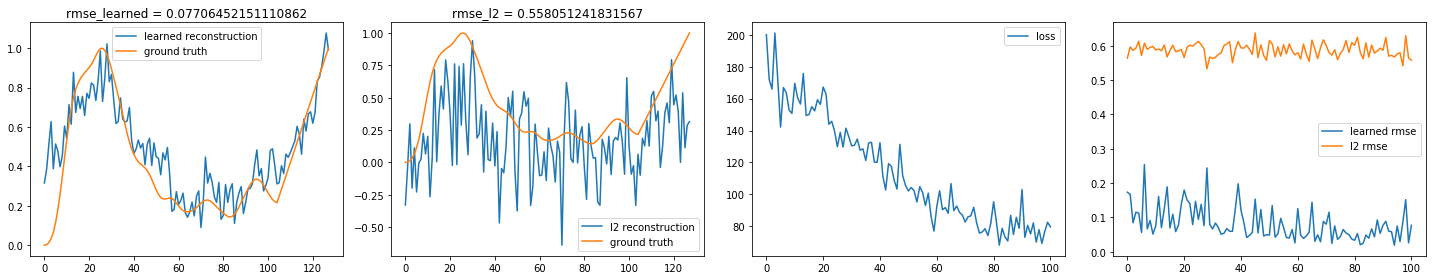

[[Batch 101/1001] [G loss: 91.789505] [Seconds: 1.547841]
[[Batch 102/1001] [G loss: 76.899658] [Seconds: 1.493873]
[[Batch 103/1001] [G loss: 80.424805] [Seconds: 1.504130]
[[Batch 104/1001] [G loss: 80.393738] [Seconds: 1.475539]
[[Batch 105/1001] [G loss: 79.051254] [Seconds: 1.578611]
[[Batch 106/1001] [G loss: 75.380127] [Seconds: 1.489020]
[[Batch 107/1001] [G loss: 69.569672] [Seconds: 1.560233]
[[Batch 108/1001] [G loss: 75.780273] [Seconds: 1.494621]
[[Batch 109/1001] [G loss: 65.649254] [Seconds: 1.497977]
[[Batch 110/1001] [G loss: 67.844254] [Seconds: 1.442120]
[[Batch 111/1001] [G loss: 74.187881] [Seconds: 1.486818]
[[Batch 112/1001] [G loss: 62.280842] [Seconds: 1.460057]
[[Batch 113/1001] [G loss: 67.779968] [Seconds: 1.521785]
[[Batch 114/1001] [G loss: 78.574432] [Seconds: 1.446881]
[[Batch 115/1001] [G loss: 64.782265] [Seconds: 1.569768]
[[Batch 116/1001] [G loss: 77.093468] [Seconds: 1.479875]
[[Batch 117/1001] [G loss: 62.719887] [Seconds: 1.494292]
[[Batch 118/10

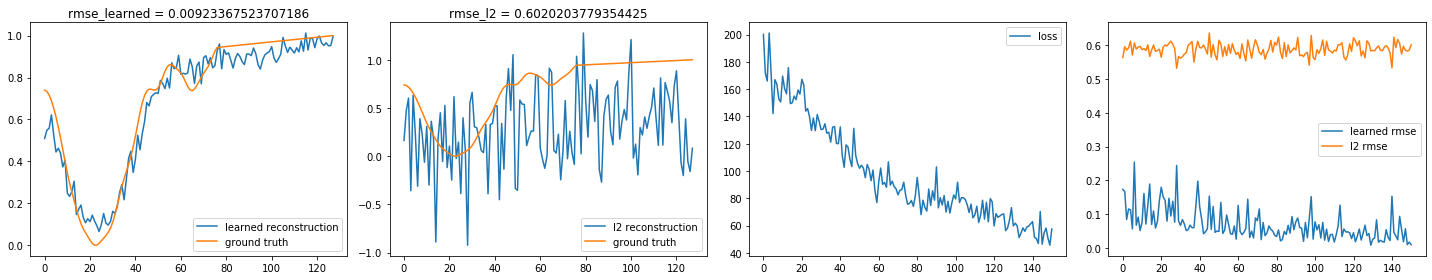

[[Batch 151/1001] [G loss: 53.529140] [Seconds: 1.544417]
[[Batch 152/1001] [G loss: 65.586884] [Seconds: 1.613822]
[[Batch 153/1001] [G loss: 45.605118] [Seconds: 1.542247]
[[Batch 154/1001] [G loss: 49.597038] [Seconds: 1.622410]
[[Batch 155/1001] [G loss: 58.439903] [Seconds: 1.503137]
[[Batch 156/1001] [G loss: 47.296371] [Seconds: 1.513547]
[[Batch 157/1001] [G loss: 54.270885] [Seconds: 1.539733]
[[Batch 158/1001] [G loss: 56.749016] [Seconds: 1.630925]
[[Batch 159/1001] [G loss: 47.708038] [Seconds: 1.512363]
[[Batch 160/1001] [G loss: 50.142601] [Seconds: 1.645457]
[[Batch 161/1001] [G loss: 46.648643] [Seconds: 1.579794]
[[Batch 162/1001] [G loss: 45.553776] [Seconds: 1.512128]
[[Batch 163/1001] [G loss: 49.856937] [Seconds: 1.535368]
[[Batch 164/1001] [G loss: 42.052151] [Seconds: 1.549838]
[[Batch 165/1001] [G loss: 44.854374] [Seconds: 1.549808]
[[Batch 166/1001] [G loss: 51.705181] [Seconds: 1.546281]
[[Batch 167/1001] [G loss: 50.746758] [Seconds: 1.578216]
[[Batch 168/10

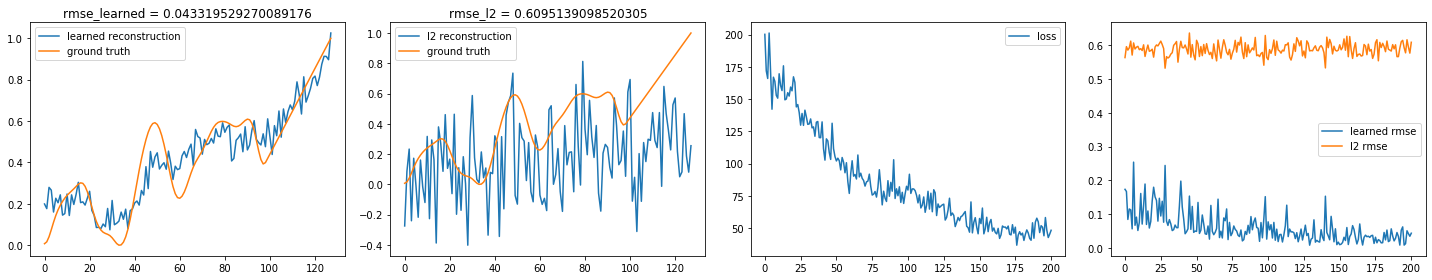

[[Batch 201/1001] [G loss: 40.702538] [Seconds: 1.625953]
[[Batch 202/1001] [G loss: 43.577080] [Seconds: 1.543497]
[[Batch 203/1001] [G loss: 58.485847] [Seconds: 1.923082]
[[Batch 204/1001] [G loss: 43.666298] [Seconds: 1.492389]
[[Batch 205/1001] [G loss: 46.027653] [Seconds: 1.676830]
[[Batch 206/1001] [G loss: 47.602074] [Seconds: 1.510701]
[[Batch 207/1001] [G loss: 44.405563] [Seconds: 1.551173]
[[Batch 208/1001] [G loss: 44.105495] [Seconds: 1.472505]
[[Batch 209/1001] [G loss: 46.799656] [Seconds: 1.496378]
[[Batch 210/1001] [G loss: 51.460339] [Seconds: 1.539077]
[[Batch 211/1001] [G loss: 50.142067] [Seconds: 1.497861]
[[Batch 212/1001] [G loss: 47.267750] [Seconds: 1.548834]
[[Batch 213/1001] [G loss: 51.445114] [Seconds: 1.476469]
[[Batch 214/1001] [G loss: 53.896942] [Seconds: 1.569785]
[[Batch 215/1001] [G loss: 48.211338] [Seconds: 1.476784]
[[Batch 216/1001] [G loss: 49.408661] [Seconds: 1.514680]
[[Batch 217/1001] [G loss: 49.596684] [Seconds: 1.554843]
[[Batch 218/10

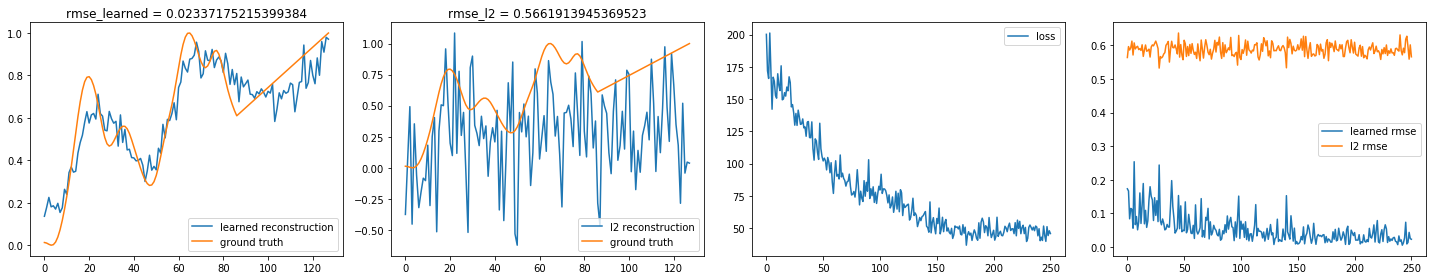

[[Batch 251/1001] [G loss: 42.076538] [Seconds: 1.564598]
[[Batch 252/1001] [G loss: 33.650803] [Seconds: 1.632865]
[[Batch 253/1001] [G loss: 48.030281] [Seconds: 1.519700]
[[Batch 254/1001] [G loss: 49.032398] [Seconds: 1.498305]
[[Batch 255/1001] [G loss: 39.701553] [Seconds: 1.538592]
[[Batch 256/1001] [G loss: 48.978127] [Seconds: 1.442707]
[[Batch 257/1001] [G loss: 48.974838] [Seconds: 1.500714]
[[Batch 258/1001] [G loss: 48.191948] [Seconds: 1.605003]
[[Batch 259/1001] [G loss: 44.028511] [Seconds: 1.472883]
[[Batch 260/1001] [G loss: 49.826717] [Seconds: 1.516101]
[[Batch 261/1001] [G loss: 50.645859] [Seconds: 1.546194]
[[Batch 262/1001] [G loss: 52.231384] [Seconds: 1.546352]
[[Batch 263/1001] [G loss: 47.182674] [Seconds: 1.602109]
[[Batch 264/1001] [G loss: 44.720573] [Seconds: 1.506530]
[[Batch 265/1001] [G loss: 46.323242] [Seconds: 1.530666]
[[Batch 266/1001] [G loss: 41.278854] [Seconds: 1.555236]
[[Batch 267/1001] [G loss: 42.946701] [Seconds: 1.571565]
[[Batch 268/10

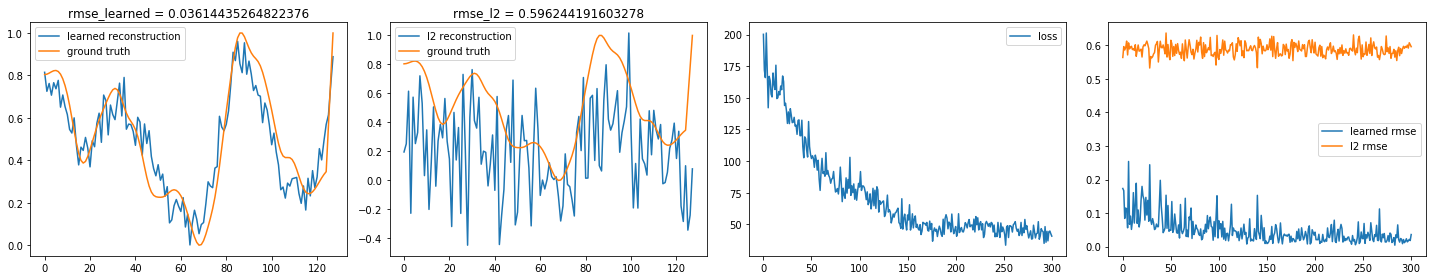

[[Batch 301/1001] [G loss: 42.954952] [Seconds: 1.534056]
[[Batch 302/1001] [G loss: 46.240028] [Seconds: 1.460783]
[[Batch 303/1001] [G loss: 36.352745] [Seconds: 1.552384]
[[Batch 304/1001] [G loss: 36.028564] [Seconds: 1.502143]
[[Batch 305/1001] [G loss: 36.293339] [Seconds: 1.499149]
[[Batch 306/1001] [G loss: 40.565948] [Seconds: 1.470350]
[[Batch 307/1001] [G loss: 52.084419] [Seconds: 1.586955]
[[Batch 308/1001] [G loss: 46.505009] [Seconds: 1.597013]
[[Batch 309/1001] [G loss: 38.446800] [Seconds: 1.592152]
[[Batch 310/1001] [G loss: 42.063286] [Seconds: 1.553008]
[[Batch 311/1001] [G loss: 40.376053] [Seconds: 1.650290]
[[Batch 312/1001] [G loss: 48.309692] [Seconds: 1.533930]
[[Batch 313/1001] [G loss: 41.098022] [Seconds: 1.554783]
[[Batch 314/1001] [G loss: 41.583504] [Seconds: 1.629874]
[[Batch 315/1001] [G loss: 39.116360] [Seconds: 1.579904]
[[Batch 316/1001] [G loss: 36.759605] [Seconds: 1.481369]
[[Batch 317/1001] [G loss: 36.805065] [Seconds: 1.558056]
[[Batch 318/10

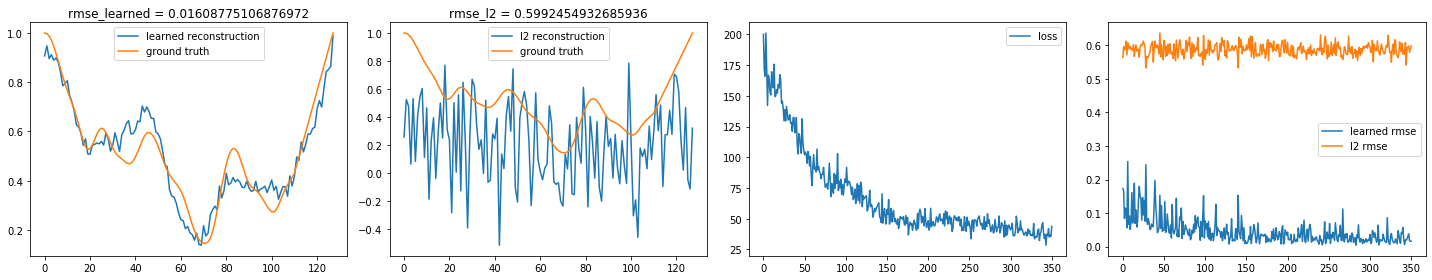

[[Batch 351/1001] [G loss: 33.761894] [Seconds: 1.462732]
[[Batch 352/1001] [G loss: 41.291084] [Seconds: 1.487778]
[[Batch 353/1001] [G loss: 36.083138] [Seconds: 1.477907]
[[Batch 354/1001] [G loss: 44.899048] [Seconds: 1.495450]
[[Batch 355/1001] [G loss: 39.198860] [Seconds: 1.561535]
[[Batch 356/1001] [G loss: 34.855873] [Seconds: 1.460299]
[[Batch 357/1001] [G loss: 34.121605] [Seconds: 1.524108]
[[Batch 358/1001] [G loss: 30.609230] [Seconds: 1.493351]
[[Batch 359/1001] [G loss: 30.558393] [Seconds: 1.531340]
[[Batch 360/1001] [G loss: 36.247108] [Seconds: 1.538121]
[[Batch 361/1001] [G loss: 40.107952] [Seconds: 1.670263]
[[Batch 362/1001] [G loss: 36.237770] [Seconds: 1.548025]
[[Batch 363/1001] [G loss: 37.230282] [Seconds: 1.554228]
[[Batch 364/1001] [G loss: 36.030235] [Seconds: 1.527738]
[[Batch 365/1001] [G loss: 38.691471] [Seconds: 1.500258]
[[Batch 366/1001] [G loss: 34.399700] [Seconds: 1.450792]
[[Batch 367/1001] [G loss: 37.150558] [Seconds: 1.948429]
[[Batch 368/10

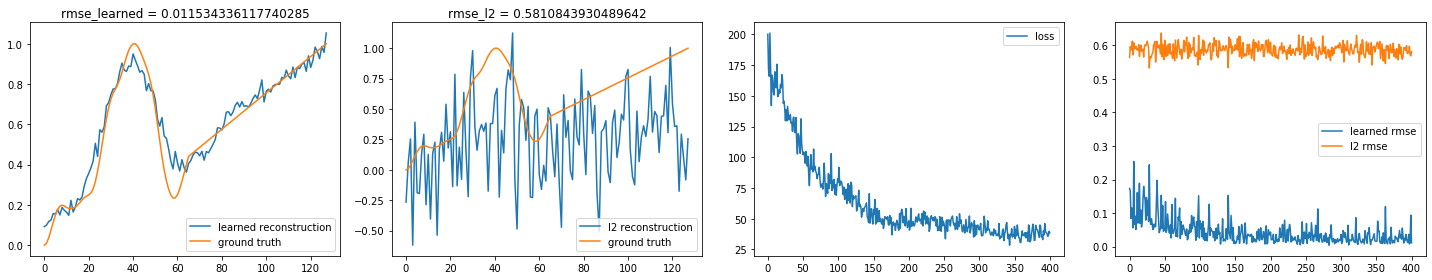

[[Batch 401/1001] [G loss: 40.068184] [Seconds: 1.546995]
[[Batch 402/1001] [G loss: 31.132607] [Seconds: 1.493159]
[[Batch 403/1001] [G loss: 34.378799] [Seconds: 1.491950]
[[Batch 404/1001] [G loss: 37.714161] [Seconds: 1.571628]
[[Batch 405/1001] [G loss: 40.230061] [Seconds: 1.552852]
[[Batch 406/1001] [G loss: 40.777340] [Seconds: 1.512553]
[[Batch 407/1001] [G loss: 41.321484] [Seconds: 1.573707]
[[Batch 408/1001] [G loss: 37.521381] [Seconds: 1.508109]
[[Batch 409/1001] [G loss: 34.593330] [Seconds: 1.503019]
[[Batch 410/1001] [G loss: 34.927494] [Seconds: 1.491784]
[[Batch 411/1001] [G loss: 34.808006] [Seconds: 1.589186]
[[Batch 412/1001] [G loss: 33.668747] [Seconds: 1.549195]
[[Batch 413/1001] [G loss: 38.091621] [Seconds: 1.569096]
[[Batch 414/1001] [G loss: 38.339108] [Seconds: 1.567446]
[[Batch 415/1001] [G loss: 43.844883] [Seconds: 1.481876]
[[Batch 416/1001] [G loss: 41.018105] [Seconds: 1.562879]
[[Batch 417/1001] [G loss: 38.158070] [Seconds: 1.596224]
[[Batch 418/10

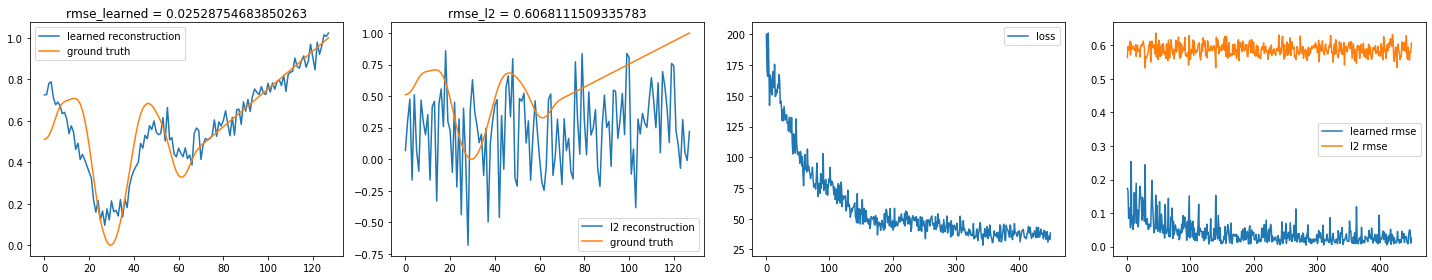

[[Batch 451/1001] [G loss: 36.758118] [Seconds: 1.570538]
[[Batch 452/1001] [G loss: 42.105476] [Seconds: 1.604743]
[[Batch 453/1001] [G loss: 38.128731] [Seconds: 1.502547]
[[Batch 454/1001] [G loss: 32.634163] [Seconds: 1.644125]
[[Batch 455/1001] [G loss: 29.712845] [Seconds: 1.528929]
[[Batch 456/1001] [G loss: 33.841152] [Seconds: 1.560354]
[[Batch 457/1001] [G loss: 44.044868] [Seconds: 1.600645]
[[Batch 458/1001] [G loss: 36.409096] [Seconds: 1.468457]
[[Batch 459/1001] [G loss: 36.327148] [Seconds: 1.449953]
[[Batch 460/1001] [G loss: 33.433487] [Seconds: 1.477947]
[[Batch 461/1001] [G loss: 36.674622] [Seconds: 1.581729]
[[Batch 462/1001] [G loss: 39.082920] [Seconds: 1.486226]
[[Batch 463/1001] [G loss: 33.726070] [Seconds: 1.499676]
[[Batch 464/1001] [G loss: 42.779854] [Seconds: 1.561427]
[[Batch 465/1001] [G loss: 35.377785] [Seconds: 1.543633]
[[Batch 466/1001] [G loss: 34.207596] [Seconds: 1.465970]
[[Batch 467/1001] [G loss: 37.297218] [Seconds: 1.502338]
[[Batch 468/10

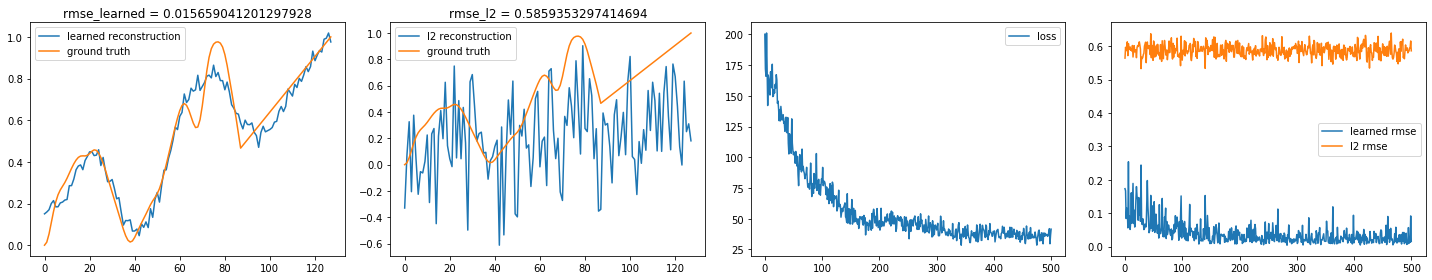

[[Batch 501/1001] [G loss: 35.454895] [Seconds: 1.487638]
[[Batch 502/1001] [G loss: 30.130222] [Seconds: 1.512029]
[[Batch 503/1001] [G loss: 33.483475] [Seconds: 1.541014]
[[Batch 504/1001] [G loss: 35.462547] [Seconds: 1.465048]
[[Batch 505/1001] [G loss: 38.970966] [Seconds: 1.652012]
[[Batch 506/1001] [G loss: 40.706192] [Seconds: 1.485936]
[[Batch 507/1001] [G loss: 36.867523] [Seconds: 1.482986]
[[Batch 508/1001] [G loss: 38.233665] [Seconds: 1.624409]
[[Batch 509/1001] [G loss: 38.384125] [Seconds: 1.466784]
[[Batch 510/1001] [G loss: 35.919827] [Seconds: 1.423912]
[[Batch 511/1001] [G loss: 34.741573] [Seconds: 1.486848]
[[Batch 512/1001] [G loss: 36.338238] [Seconds: 1.473806]
[[Batch 513/1001] [G loss: 38.402653] [Seconds: 1.457375]
[[Batch 514/1001] [G loss: 36.992599] [Seconds: 2.291512]
[[Batch 515/1001] [G loss: 39.488907] [Seconds: 3.476569]
[[Batch 516/1001] [G loss: 32.545494] [Seconds: 1.651102]
[[Batch 517/1001] [G loss: 35.343452] [Seconds: 1.540744]
[[Batch 518/10

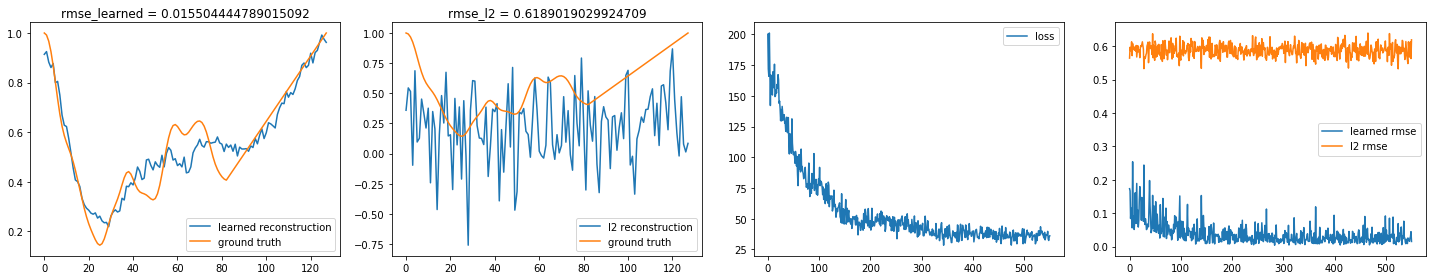

[[Batch 551/1001] [G loss: 30.536009] [Seconds: 1.438107]
[[Batch 552/1001] [G loss: 30.895618] [Seconds: 1.483817]
[[Batch 553/1001] [G loss: 35.571911] [Seconds: 1.569420]
[[Batch 554/1001] [G loss: 41.905582] [Seconds: 1.456024]
[[Batch 555/1001] [G loss: 34.600979] [Seconds: 1.462678]
[[Batch 556/1001] [G loss: 29.404327] [Seconds: 1.500876]
[[Batch 557/1001] [G loss: 36.679489] [Seconds: 1.521777]
[[Batch 558/1001] [G loss: 34.836571] [Seconds: 1.460655]
[[Batch 559/1001] [G loss: 36.324951] [Seconds: 1.553493]
[[Batch 560/1001] [G loss: 31.938492] [Seconds: 1.508719]
[[Batch 561/1001] [G loss: 32.005516] [Seconds: 1.508387]
[[Batch 562/1001] [G loss: 30.654997] [Seconds: 1.452779]
[[Batch 563/1001] [G loss: 35.359467] [Seconds: 1.527963]
[[Batch 564/1001] [G loss: 33.892475] [Seconds: 1.469234]
[[Batch 565/1001] [G loss: 33.733757] [Seconds: 1.471119]
[[Batch 566/1001] [G loss: 35.541908] [Seconds: 1.474391]
[[Batch 567/1001] [G loss: 30.164192] [Seconds: 1.476111]
[[Batch 568/10

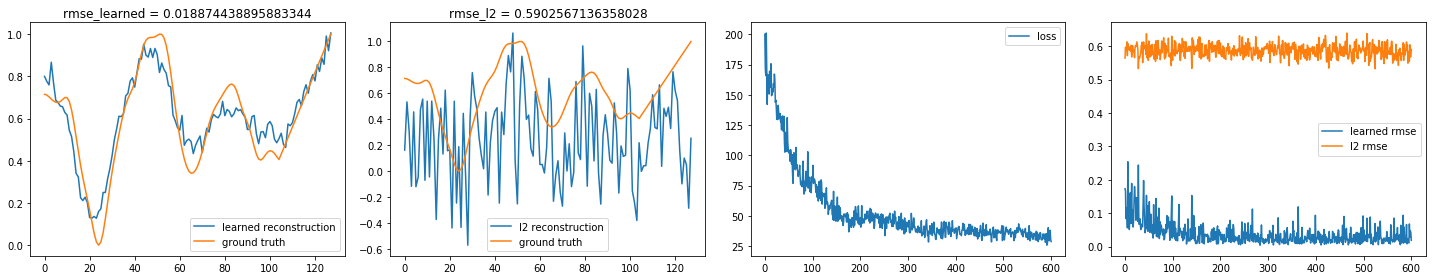

[[Batch 601/1001] [G loss: 32.381229] [Seconds: 1.467399]
[[Batch 602/1001] [G loss: 35.144096] [Seconds: 1.443681]
[[Batch 603/1001] [G loss: 33.469025] [Seconds: 1.555469]
[[Batch 604/1001] [G loss: 31.049473] [Seconds: 1.555065]
[[Batch 605/1001] [G loss: 26.370548] [Seconds: 1.536876]
[[Batch 606/1001] [G loss: 35.432411] [Seconds: 1.492124]
[[Batch 607/1001] [G loss: 28.617119] [Seconds: 1.561689]
[[Batch 608/1001] [G loss: 30.275509] [Seconds: 1.451687]
[[Batch 609/1001] [G loss: 32.391159] [Seconds: 1.469118]
[[Batch 610/1001] [G loss: 31.925913] [Seconds: 1.519794]
[[Batch 611/1001] [G loss: 33.240612] [Seconds: 1.454013]
[[Batch 612/1001] [G loss: 30.066799] [Seconds: 1.440885]
[[Batch 613/1001] [G loss: 31.658951] [Seconds: 1.490418]
[[Batch 614/1001] [G loss: 33.383709] [Seconds: 1.501216]
[[Batch 615/1001] [G loss: 35.149456] [Seconds: 1.454065]
[[Batch 616/1001] [G loss: 31.293039] [Seconds: 1.538333]
[[Batch 617/1001] [G loss: 29.419302] [Seconds: 1.557609]
[[Batch 618/10

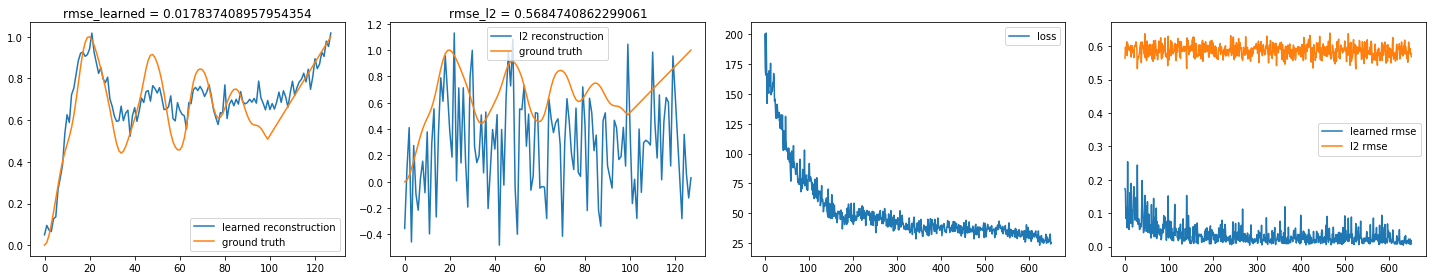

[[Batch 651/1001] [G loss: 29.982716] [Seconds: 1.533342]
[[Batch 652/1001] [G loss: 24.800251] [Seconds: 1.482109]
[[Batch 653/1001] [G loss: 29.610754] [Seconds: 1.494404]
[[Batch 654/1001] [G loss: 28.485352] [Seconds: 1.550029]
[[Batch 655/1001] [G loss: 24.841656] [Seconds: 1.458077]
[[Batch 656/1001] [G loss: 25.020721] [Seconds: 1.459663]
[[Batch 657/1001] [G loss: 29.554016] [Seconds: 1.449154]
[[Batch 658/1001] [G loss: 25.047295] [Seconds: 1.462604]
[[Batch 659/1001] [G loss: 26.272333] [Seconds: 1.459029]
[[Batch 660/1001] [G loss: 22.716389] [Seconds: 1.522420]
[[Batch 661/1001] [G loss: 24.582848] [Seconds: 1.489033]
[[Batch 662/1001] [G loss: 23.261890] [Seconds: 1.492715]
[[Batch 663/1001] [G loss: 28.837538] [Seconds: 1.446259]
[[Batch 664/1001] [G loss: 27.452147] [Seconds: 1.540940]
[[Batch 665/1001] [G loss: 25.122486] [Seconds: 1.430781]
[[Batch 666/1001] [G loss: 22.553352] [Seconds: 1.469809]
[[Batch 667/1001] [G loss: 28.558130] [Seconds: 1.503121]
[[Batch 668/10

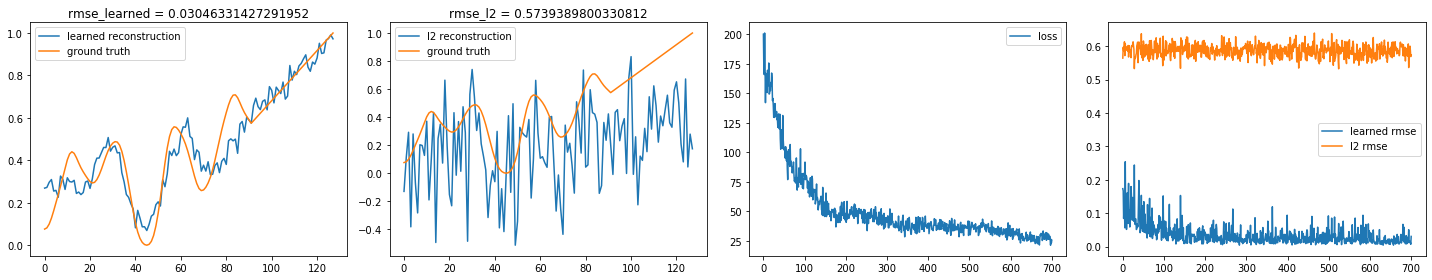

[[Batch 701/1001] [G loss: 27.917679] [Seconds: 1.419561]
[[Batch 702/1001] [G loss: 26.578384] [Seconds: 1.528296]
[[Batch 703/1001] [G loss: 23.931973] [Seconds: 1.434853]
[[Batch 704/1001] [G loss: 30.434902] [Seconds: 1.475898]
[[Batch 705/1001] [G loss: 23.352577] [Seconds: 1.499081]
[[Batch 706/1001] [G loss: 26.425222] [Seconds: 1.462671]
[[Batch 707/1001] [G loss: 30.030491] [Seconds: 1.441446]
[[Batch 708/1001] [G loss: 23.494923] [Seconds: 1.566593]
[[Batch 709/1001] [G loss: 22.473528] [Seconds: 1.457859]
[[Batch 710/1001] [G loss: 22.951870] [Seconds: 1.429024]
[[Batch 711/1001] [G loss: 26.193113] [Seconds: 1.448924]
[[Batch 712/1001] [G loss: 21.453228] [Seconds: 1.497649]
[[Batch 713/1001] [G loss: 31.380533] [Seconds: 1.492785]
[[Batch 714/1001] [G loss: 31.091187] [Seconds: 1.438666]
[[Batch 715/1001] [G loss: 23.389435] [Seconds: 1.520392]
[[Batch 716/1001] [G loss: 21.346085] [Seconds: 1.426635]
[[Batch 717/1001] [G loss: 23.335697] [Seconds: 1.466352]
[[Batch 718/10

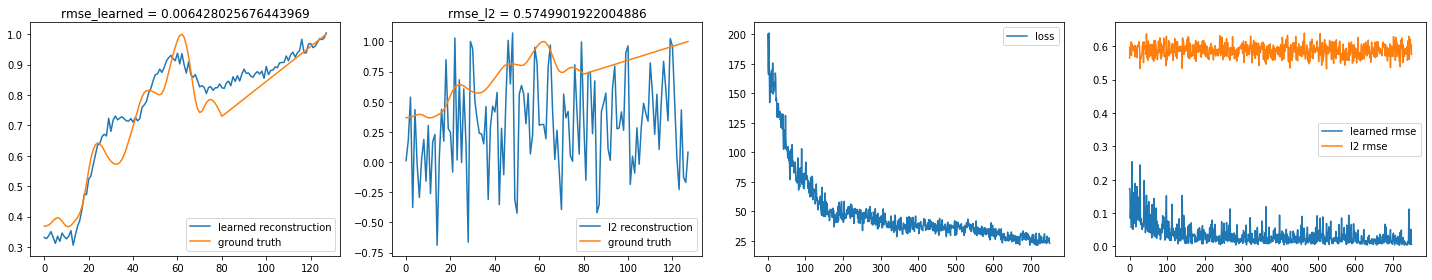

[[Batch 751/1001] [G loss: 20.419388] [Seconds: 1.493542]
[[Batch 752/1001] [G loss: 24.617691] [Seconds: 1.413904]
[[Batch 753/1001] [G loss: 27.131969] [Seconds: 1.493908]
[[Batch 754/1001] [G loss: 28.219072] [Seconds: 1.518146]
[[Batch 755/1001] [G loss: 23.721764] [Seconds: 1.463020]
[[Batch 756/1001] [G loss: 30.856737] [Seconds: 1.622108]
[[Batch 757/1001] [G loss: 21.894983] [Seconds: 1.517894]
[[Batch 758/1001] [G loss: 26.437235] [Seconds: 1.471099]
[[Batch 759/1001] [G loss: 23.950977] [Seconds: 1.587542]
[[Batch 760/1001] [G loss: 21.765976] [Seconds: 1.476431]
[[Batch 761/1001] [G loss: 25.518658] [Seconds: 1.507111]
[[Batch 762/1001] [G loss: 23.745991] [Seconds: 1.460245]
[[Batch 763/1001] [G loss: 22.068424] [Seconds: 1.478930]
[[Batch 764/1001] [G loss: 22.788603] [Seconds: 1.444067]
[[Batch 765/1001] [G loss: 27.354891] [Seconds: 1.500834]
[[Batch 766/1001] [G loss: 24.412979] [Seconds: 1.527705]
[[Batch 767/1001] [G loss: 21.825920] [Seconds: 1.479792]
[[Batch 768/10

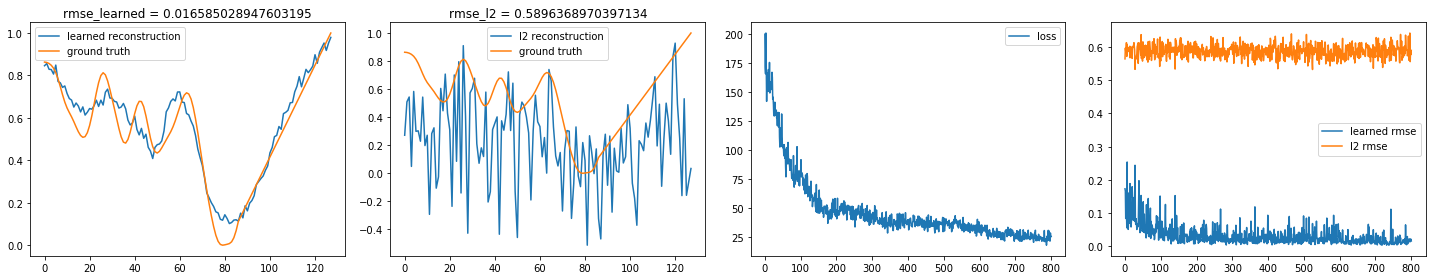

[[Batch 801/1001] [G loss: 22.977247] [Seconds: 1.424500]
[[Batch 802/1001] [G loss: 22.204506] [Seconds: 1.434928]
[[Batch 803/1001] [G loss: 25.890930] [Seconds: 1.591028]
[[Batch 804/1001] [G loss: 28.033890] [Seconds: 1.483005]
[[Batch 805/1001] [G loss: 25.557575] [Seconds: 1.467850]
[[Batch 806/1001] [G loss: 20.204983] [Seconds: 1.529520]
[[Batch 807/1001] [G loss: 23.428429] [Seconds: 1.472461]
[[Batch 808/1001] [G loss: 26.798004] [Seconds: 1.458925]
[[Batch 809/1001] [G loss: 26.925999] [Seconds: 1.489450]
[[Batch 810/1001] [G loss: 22.694424] [Seconds: 1.524240]
[[Batch 811/1001] [G loss: 28.941885] [Seconds: 1.536651]
[[Batch 812/1001] [G loss: 25.168102] [Seconds: 1.480992]
[[Batch 813/1001] [G loss: 23.534307] [Seconds: 1.430143]
[[Batch 814/1001] [G loss: 24.037342] [Seconds: 1.477684]
[[Batch 815/1001] [G loss: 27.618769] [Seconds: 1.457139]
[[Batch 816/1001] [G loss: 30.091190] [Seconds: 1.542980]
[[Batch 817/1001] [G loss: 24.047264] [Seconds: 1.435182]
[[Batch 818/10

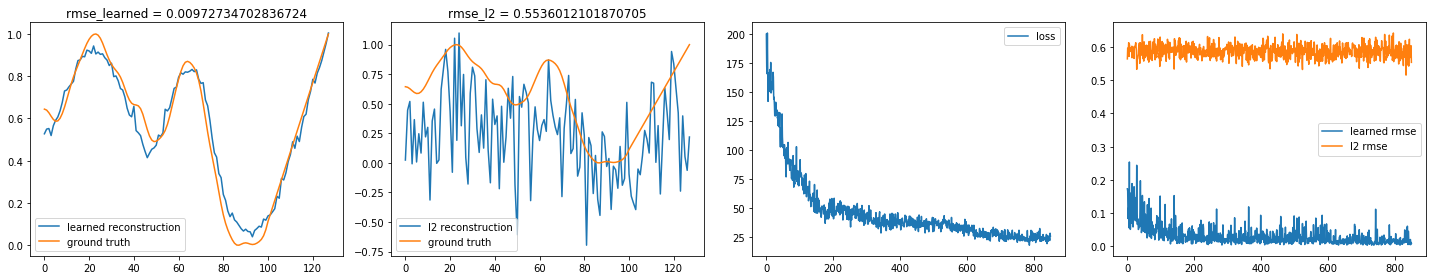

[[Batch 851/1001] [G loss: 18.267420] [Seconds: 1.475658]
[[Batch 852/1001] [G loss: 22.629612] [Seconds: 1.472082]
[[Batch 853/1001] [G loss: 25.718285] [Seconds: 1.443373]
[[Batch 854/1001] [G loss: 23.466757] [Seconds: 1.523685]
[[Batch 855/1001] [G loss: 24.848434] [Seconds: 1.454003]
[[Batch 856/1001] [G loss: 25.122513] [Seconds: 1.460491]
[[Batch 857/1001] [G loss: 20.044357] [Seconds: 1.464042]
[[Batch 858/1001] [G loss: 27.309513] [Seconds: 1.475425]
[[Batch 859/1001] [G loss: 24.199043] [Seconds: 1.420182]
[[Batch 860/1001] [G loss: 21.547922] [Seconds: 1.498929]
[[Batch 861/1001] [G loss: 23.303694] [Seconds: 1.547687]
[[Batch 862/1001] [G loss: 23.894772] [Seconds: 1.508408]
[[Batch 863/1001] [G loss: 21.580046] [Seconds: 1.534295]
[[Batch 864/1001] [G loss: 22.234179] [Seconds: 1.465758]
[[Batch 865/1001] [G loss: 20.709717] [Seconds: 1.452494]
[[Batch 866/1001] [G loss: 23.075596] [Seconds: 1.493009]
[[Batch 867/1001] [G loss: 28.156181] [Seconds: 1.519923]
[[Batch 868/10

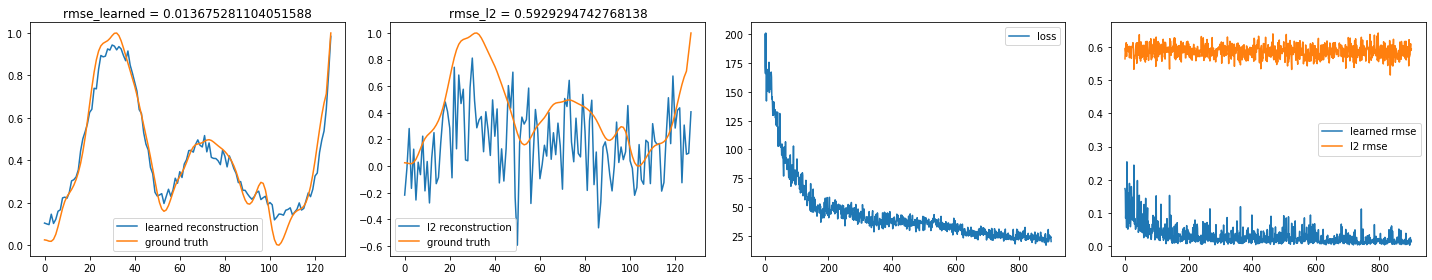

[[Batch 901/1001] [G loss: 28.343479] [Seconds: 2.027597]
[[Batch 902/1001] [G loss: 22.815636] [Seconds: 1.929645]
[[Batch 903/1001] [G loss: 21.037683] [Seconds: 1.934270]
[[Batch 904/1001] [G loss: 22.784725] [Seconds: 1.452729]
[[Batch 905/1001] [G loss: 22.135595] [Seconds: 1.510316]
[[Batch 906/1001] [G loss: 24.538792] [Seconds: 1.974377]
[[Batch 907/1001] [G loss: 21.951065] [Seconds: 2.284511]
[[Batch 908/1001] [G loss: 25.490387] [Seconds: 1.986435]
[[Batch 909/1001] [G loss: 25.951321] [Seconds: 1.568930]
[[Batch 910/1001] [G loss: 21.409969] [Seconds: 1.613894]
[[Batch 911/1001] [G loss: 24.539207] [Seconds: 1.756423]
[[Batch 912/1001] [G loss: 22.468712] [Seconds: 3.026061]
[[Batch 913/1001] [G loss: 23.944651] [Seconds: 2.335536]
[[Batch 914/1001] [G loss: 24.637075] [Seconds: 1.596996]
[[Batch 915/1001] [G loss: 22.788204] [Seconds: 1.681110]
[[Batch 916/1001] [G loss: 25.713902] [Seconds: 1.624944]
[[Batch 917/1001] [G loss: 20.324688] [Seconds: 2.177143]
[[Batch 918/10

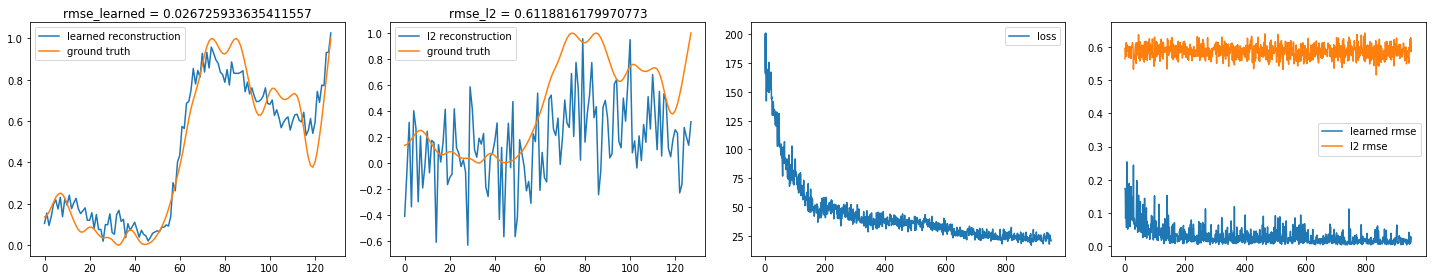

[[Batch 951/1001] [G loss: 24.694424] [Seconds: 1.489581]
[[Batch 952/1001] [G loss: 21.691908] [Seconds: 1.470798]
[[Batch 953/1001] [G loss: 23.973076] [Seconds: 1.514928]
[[Batch 954/1001] [G loss: 22.006016] [Seconds: 1.521548]
[[Batch 955/1001] [G loss: 22.611290] [Seconds: 1.454286]
[[Batch 956/1001] [G loss: 23.701672] [Seconds: 1.455247]
[[Batch 957/1001] [G loss: 20.329987] [Seconds: 1.470318]
[[Batch 958/1001] [G loss: 21.738083] [Seconds: 1.435321]
[[Batch 959/1001] [G loss: 22.878786] [Seconds: 1.474309]
[[Batch 960/1001] [G loss: 22.038223] [Seconds: 1.477057]
[[Batch 961/1001] [G loss: 23.779697] [Seconds: 1.519817]
[[Batch 962/1001] [G loss: 23.026878] [Seconds: 1.504682]
[[Batch 963/1001] [G loss: 27.078796] [Seconds: 1.485095]
[[Batch 964/1001] [G loss: 24.105425] [Seconds: 1.454917]
[[Batch 965/1001] [G loss: 22.093567] [Seconds: 1.543317]
[[Batch 966/1001] [G loss: 20.201107] [Seconds: 1.435334]
[[Batch 967/1001] [G loss: 23.904755] [Seconds: 1.457287]
[[Batch 968/10

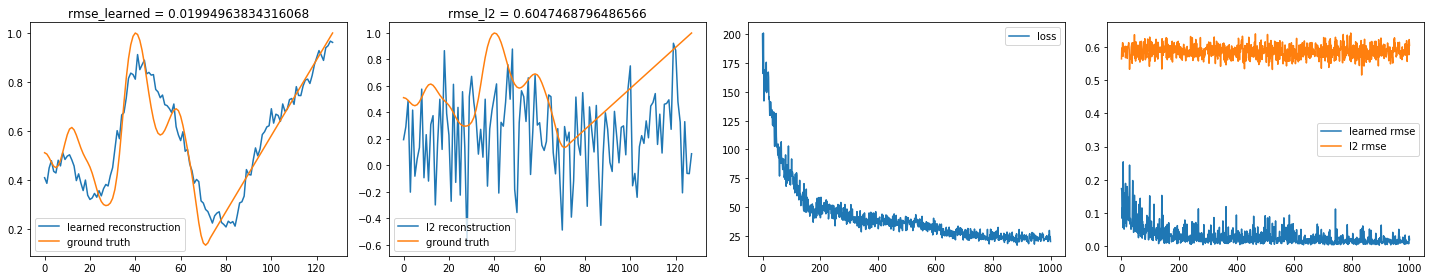

In [14]:
for i in range(n_batches):
    # Load a learning rate from file.
    new_lr = float(np.loadtxt('lr_file'))
    if new_lr != lr:
        lr = new_lr
        print("New lr =", lr)
        for g in optimizer.param_groups:
                g['lr'] = lr

    tick_train_step = time.time()

    # Create a batch of data for training.
    y_delta, delta, x, y = get_noisy_batch(32, relative_delta, function_length)
    y_delta = torch.cuda.FloatTensor(y_delta.T)
    delta = torch.cuda.FloatTensor([delta])
    x = torch.cuda.FloatTensor(x.T)
    y = torch.cuda.FloatTensor(y.T)

    # Initalize x_star as 0
    x_star = Variable(torch.zeros(x.shape, dtype=torch.float32, device='cuda'))

    # Prepare optimizer for batch
    optimizer.zero_grad()

    # Propagate batch
    x_predict = generator(x_star, A_torch, y_delta, delta)

    # Calculate loss
    loss = torch.sum((x - x_predict)**2)

    # Calculate gradients
    loss.backward()

    # Apply gradients
    optimizer.step()

    ####################################################################
    # Print and log progress and compare it with best l2 reconstruction
    print(
        "[[Batch %d/%d] [G loss: %f] [Seconds: %f]"
        % (i, n_batches, loss.item(), time.time() - tick_train_step)
    )
    losses += [loss.item()]



    mse = np.linalg.norm(x_predict.cpu().detach().numpy()[0] - x.cpu().numpy()[0])**2
    rmse = mse / np.linalg.norm(x.cpu().numpy()[0])**2
    example_rmse += [rmse]

    if batches_done % 50 == 0:
        plt.subplot(141), plt.plot(x_predict.detach().cpu().numpy()[0], label="learned reconstruction")
        plt.subplot(141), plt.plot(x.cpu().numpy()[0], label="ground truth")
        plt.subplot(141), plt.title(f"rmse_learned = {rmse}")
        plt.subplot(141), plt.legend()

    x_l2 = get_best_l2(A,
                       y_delta.detach().cpu().numpy()[0],
                       x.detach().cpu().numpy()[0])

    mse_2 = np.linalg.norm(x.detach().cpu().numpy()[0] - x_l2)**2
    rmse_2 = mse_2 / np.linalg.norm(x.detach().cpu().numpy()[0])**2
    example_rmse_l2 += [rmse_2]
    if batches_done % 50 == 0:
        plt.subplot(142), plt.plot(x_l2, label="l2 reconstruction")
        plt.subplot(142), plt.plot(x.cpu().numpy()[0], label="ground truth")
        plt.subplot(142), plt.title(f"rmse_l2 = {rmse_2}")
        plt.subplot(142), plt.legend()

        plt.subplot(143), plt.plot(losses, label="loss")
        plt.subplot(143), plt.legend()

        plt.subplot(144), plt.plot(example_rmse, label="learned rmse")
        plt.subplot(144), plt.plot(example_rmse_l2, label="l2 rmse")
        plt.subplot(144), plt.legend()

        fig = plt.gcf()
        fig.set_size_inches(20, 4)
        plt.tight_layout()
        plt.show()

    batches_done += 1